In [1]:
from darkspirals.disc import Disc
from darkspirals.substructure.realization import SubstructureRealization
from galpy.potential import MWPotential2014
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import astropy.units as apu
from copy import deepcopy
from darkspirals.orbit_util import integrate_single_orbit
from darkspirals.substructure.dsphr import PopulationdSphr
from darkspirals.distribution_function.compute_df import compute_df_from_orbits, compute_df_from_actions

plt.rcParams['axes.linewidth'] = 2.
plt.rcParams['xtick.major.width'] = 2.
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams.update({'font.size': 16})

try:
    from palettable.scientific.diverging import Vik_20 as cmap
    cmap = cmap.get_mpl_colormap()
except:
    print('could not find palettable; using a matplotlib cmap instead')
    cmap = plt.get_cmap('bwr')

A new version of galpy (1.10.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


### This follows the example_notebook but includes dark subhalos in addition to Sagittarius; note that this will take much longer to run 

In [2]:
z_min_max = 1.5
vz_min_max = 100
phase_space_resolution = 100
z = np.linspace(-z_min_max,z_min_max,phase_space_resolution)
vz = np.linspace(-vz_min_max, vz_min_max, phase_space_resolution)
galactic_potential = MWPotential2014
time_Gyr = np.linspace(0.0, -1., 800) * apu.Gyr
disc = Disc(galactic_potential, galactic_potential, z_min_max, vz_min_max, phase_space_resolution, 
                time_Gyr, parallelize_action_angle_computation=True, compute_upfront=True)
print('DONE.')

DONE.


### Generate the population of perturbers and show the vertical force

realization contains: 16 subhlaos


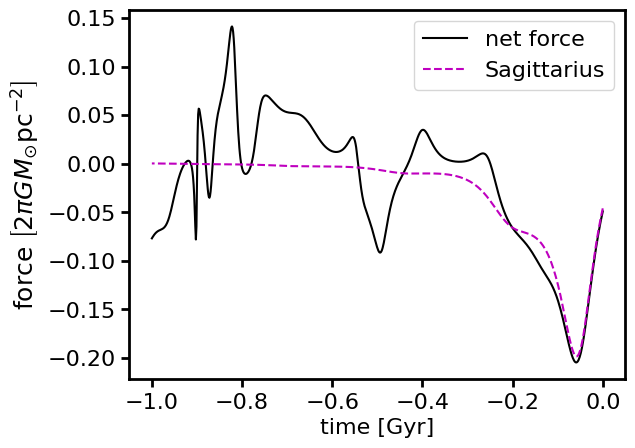

In [21]:
np.random.seed(10000)
r_min = 25 # keep everything that passes within r_min kpc of the solar position
# create a dummy class here
subhalo_abundance = 2000.0
log10_mlow = np.log10(5*10**7) # can make this lower, but will take much longer to run and uses a lot of RAM
realization = SubstructureRealization.withDistanceCut(disc, norm=subhalo_abundance, 
                                                      r_min=r_min, 
                                                      num_halos_scale=1.0, 
                                                      m_low=10**log10_mlow, 
                                                      m_high=10**8.0, 
                                                      t_max=-1.2)
print('realization contains: ' + str(len(realization.orbits))+' subhlaos')
# now add Sag. 
realization.add_dwarf_galaxies(include_dwarf_list=['Sagittarius'],
                               log10_dsphr_masses={'Sagittarius': 9.})

# calculate the force exerted by the population at the solar position
f = 0
for satellite in realization.orbits:
    f += satellite.force_exerted(disc, physical_units=True)
plt.plot(time_Gyr, f, color='k', label='net force')
f_sagittarius = realization.orbits[-1].force_exerted(disc, physical_units=True)
plt.plot(time_Gyr, f_sagittarius, color='m', linestyle='--', label='Sagittarius')
ax = plt.gca()
ax.set_xlabel('time [Gyr]', fontsize=16)
ax.set_ylabel('force '+r'$\left[2 \pi G M_{\odot} \rm{pc^{-2}}\right]$', fontsize=18)
plt.legend()
plt.show()

### Now calculate the force across the phase space exerted by the satellites, and the resulting change in the vertical action

We'll plot a couple of examples

17


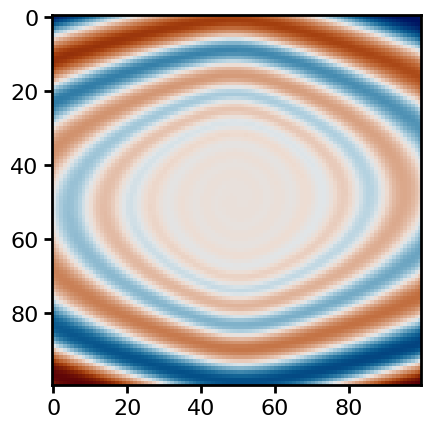

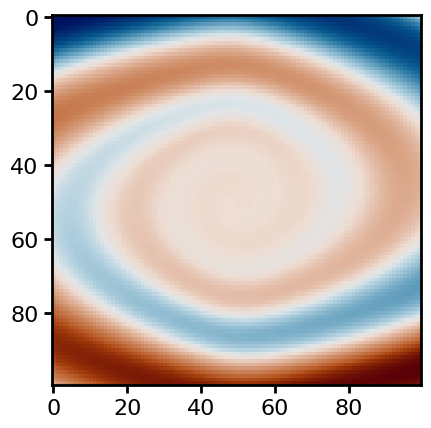

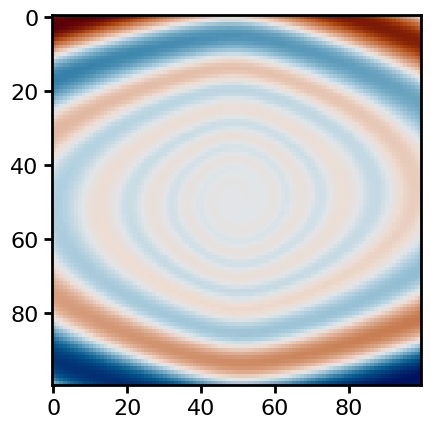

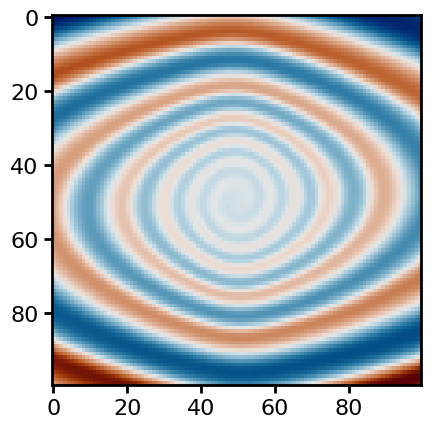

In [22]:
forces, _, _ = disc.compute_satellite_forces(realization.orbits, realization.potentials)
deltaJ_list = disc.compute_deltaJ_from_forces(forces)
print(len(deltaJ_list))
# show a few random subhalo perturbations
for index in [0,1,2,3]:
    plt.imshow(np.rot90(deltaJ_list[index]), cmap=cmap); plt.show()

### Perturber impact times 
After using the compute_satellite_forces method, each perturber will have an impact time attribute. The impact time associated with each subhalo is marked as a vertical dotted line. 

The perturbers themselves are modified versions of the Orbit class in galpy

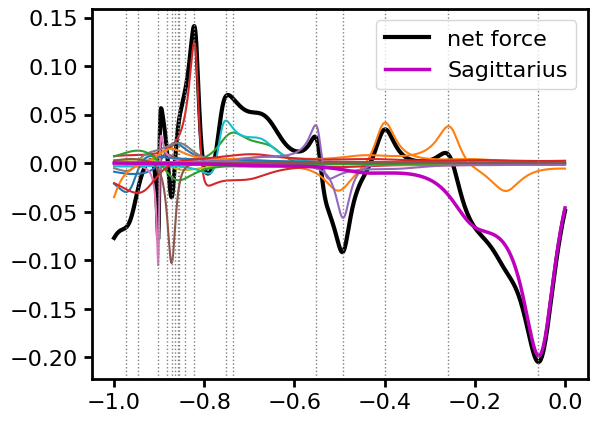

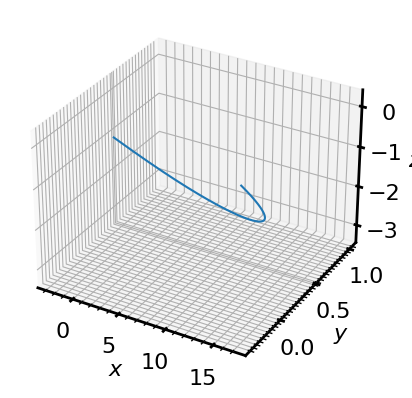

In [27]:
plt.plot(time_Gyr, f, color='k', lw=3, label='net force')
for i, perturber in enumerate(realization.orbits):
    if i == len(realization.orbits)-1:
        # dwarf galaxies are at the end of the list, and Sagittarius is the only dwarf galaxy we included 
        plt.plot(time_Gyr, perturber.force_exerted(disc, physical_units=True), lw=2.5,label='Sagittarius', color='m')
    else:
        plt.plot(time_Gyr, perturber.force_exerted(disc, physical_units=True))
    plt.axvline(-perturber.impact_time, color='0.5', lw=1, linestyle=':')
plt.legend()

print(perturber)
perturber.plot3d()

### Compute the distribution function

In [28]:
# in equilibrium
deltaJ_eq = 0.0
vdis = 15.2 # velocity dispersion
df_eq = compute_df_from_actions(disc, 
                           vdis, 
                           deltaJ_net=deltaJ_eq,
                           df_model='LI&WIDROW') # no diffusion 
df_perturbed = compute_df_from_actions(disc, 
                           vdis, 
                           deltaJ_net=deltaJ_list,
                           df_model='LI&WIDROW') # no diffusion 

### Plot observables

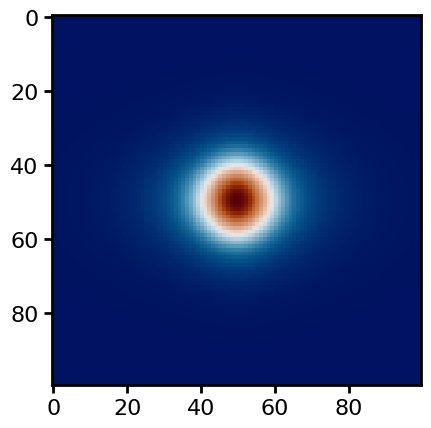

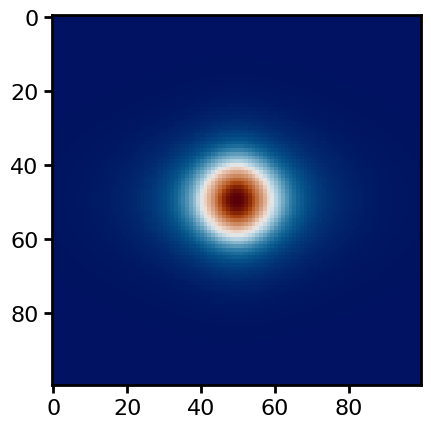

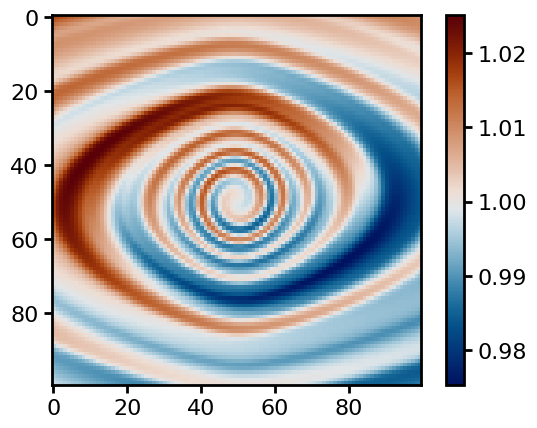

In [29]:
plt.imshow(np.rot90(df_eq.function), cmap=cmap); plt.show()
plt.imshow(np.rot90(df_perturbed.function), cmap=cmap); plt.show()
im=plt.imshow(np.rot90(df_perturbed.function/df_eq.function), cmap=cmap); 
plt.colorbar(im,cmap=cmap); plt.show()

### Add diffusion 

Evaluating the diffusion model is fairly slow. For this realization of subhalos many of the strongest perturbations happened at $t > 0.6 \ \rm{Gyr}$ in the past (see the force figure in the earlier cell that included impact times as vertical lines). Therefore, we expect a lot of the structure we see in the distribution function will fade away... 

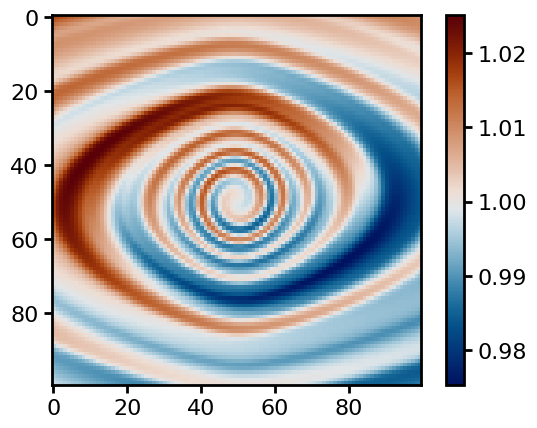

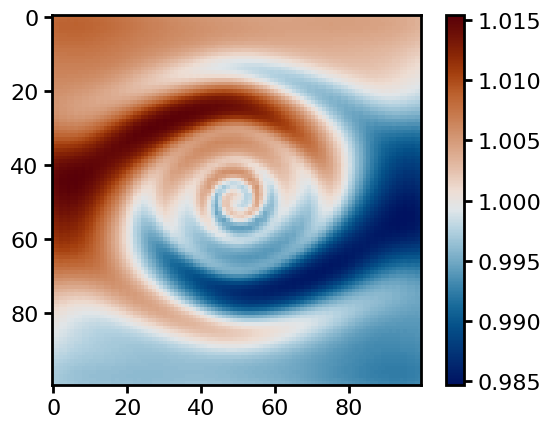

In [30]:
from darkspirals.diffusion import DiffusionConvolutionSpatiallyVarying

diffusion_model = DiffusionConvolutionSpatiallyVarying(disc)
df, deltaJ_with_diffusion = compute_df_from_orbits(disc,
                                                   vdis,
                                                   realization.orbits, 
                                                   realization.potentials, 
                                                   df_model='LI&WIDROW',
                                                   diffusion_model=diffusion_model)

df_perturbed_with_diffusion = compute_df_from_actions(disc, 
                           vdis, 
                           deltaJ_net=deltaJ_with_diffusion,
                           df_model='LI&WIDROW') # no diffusion 

im=plt.imshow(np.rot90(df_perturbed.function/df_eq.function), cmap=cmap); 
plt.colorbar(im,cmap=cmap); plt.show()

im=plt.imshow(np.rot90(df_perturbed_with_diffusion.function/df_eq.function), cmap=cmap); 
plt.colorbar(im,cmap=cmap); plt.show()

### Calculation of other properties from the distribution function 

The distribution function classes (see darkspirals.distribution_function.base, darkspirals.distribution_function.df_models) have built-in methods for calculating observables 

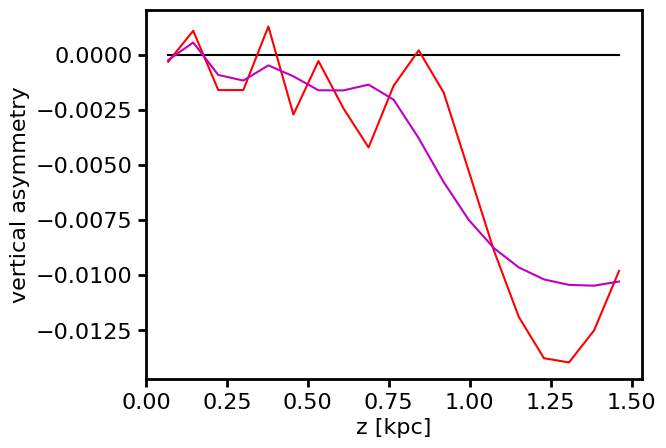

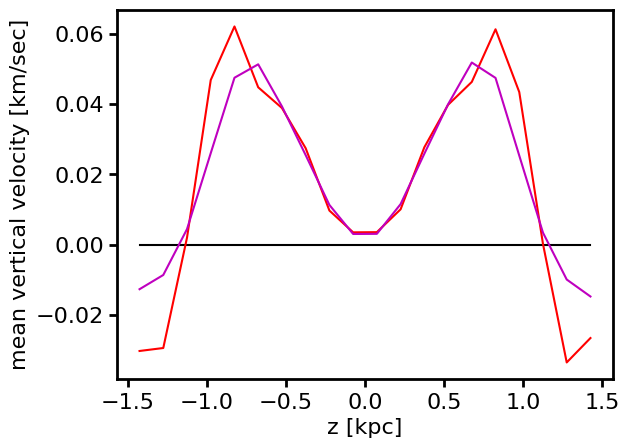

In [31]:
z_eval = np.linspace(0.03, 1.5, 20)
z, vertical_asymmetry = df_eq.vertical_asymmetry(z_eval)
plt.plot(z, vertical_asymmetry, color='k', label='equilibrium')

z, vertical_asymmetry = df_perturbed.vertical_asymmetry(z_eval)
plt.plot(z, vertical_asymmetry, color='r', label='no diffusion')

z, vertical_asymmetry = df_perturbed_with_diffusion.vertical_asymmetry(z_eval)
plt.plot(z, vertical_asymmetry, color='m', label='with diffusion')
plt.xlabel('z [kpc]', fontsize=16)
plt.ylabel('vertical asymmetry', fontsize=16)
plt.show()

z_eval = np.linspace(-1.5, 1.5, 21)
z, mvz = df_eq.mean_vertical_velocity(z_eval)
plt.plot(z, mvz, color='k', label='equilibrium')

z, mvz = df_perturbed.mean_vertical_velocity(z_eval)
plt.plot(z, mvz, color='r', label='no diffusion')

z, mvz = df_perturbed_with_diffusion.mean_vertical_velocity(z_eval)
plt.plot(z, mvz, color='m', label='with diffusion')

plt.xlabel('z [kpc]', fontsize=16)
plt.ylabel('mean vertical velocity [km/sec]', fontsize=16)
plt.show()